In [15]:
import copy
import csv
from IPython.display import Image
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import open3d as o3d
import os
from pathlib import Path
from scipy.spatial.transform import Rotation as R

np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

# Data Structure

For this notebook, you are required to stored your data in the following data structure:

- {scene_dir}/
    - pointcloud/
        - *.pcd (x y z intensity)
    - camera_calibration_*/
        - .csv or .json (x,y,z,rotation_x,rotation_y,rotatation_z,rotation_w,f_x,f_y,c_x,c_y)
    - camera_*/
        - *.jpg
    - location_poses/
        - .csv or .json (x,y,z,rotation_x,rotation_y,rotatation_z,rotation_w)

scene1 provides an example using .csv files.
scene2 provides an example using .json files.

See below steps for more details.


# Step 0 - Set scene directory to use

In [16]:
scene_dir = "scene001" # scene directory to load files from
frame_num = 0 # frame number to load in step 1 and 2

# Step 1 - Validate pointcloud

Place your pointcloud files in `{base_dir}/pointcloud/`.

For this notebook, your pointcloud files must already be in the `.pcd` format, however, we natively support these formats by the Sama Platform:
- .pcd(ascii, binary, binary compressed)
- .las
- .ply
- See full list here. 
- We also support the dimension `insensity`. If they need to be normalized, talk to your Sama representative.

Important! Your camera calibration(Step #2) and pose data(Step #3) need to be in the same coordinate system as the pointcloud.
e.g. if your pointcloud is in the vehicle frame of reference, so must your camera calibration and pose data. 

In [17]:
# Load the first frame of the pcds.

if not os.path.isdir(f"{scene_dir}"):
    raise FileNotFoundError(f"{scene_dir} not found")

pcd_dir = f"{scene_dir}/pointcloud/"
pcd_filenames = [f for f in sorted(os.listdir(pcd_dir)) if os.path.splitext(f)[1] == '.pcd']
pcd_file = pcd_dir + pcd_filenames[frame_num]
print(pcd_file)

# Visualize the first frame.
pcd_raw = o3d.t.io.read_point_cloud(pcd_file)
pcd = o3d.t.geometry.PointCloud(pcd_raw.point['positions'].to(o3d.core.float32))
if 'intensity' in pcd_raw.point:
    pcd.point['intensity'] = pcd_raw.point['intensity'].to(o3d.core.float32)


origin = o3d.geometry.TriangleMesh.create_coordinate_frame()
pcd_legacy = pcd.to_legacy()
o3d.visualization.draw_geometries([pcd_legacy, origin])

scene001/pointcloud/000010_refl.pcd


# Step 2 - Validate camera calibration

.csv and .json are supported for the camera calibration: 
- camera pose in pointcloud coordinates - x,y,z,rotation_x,rotation_y,rotatation_z,rotation_w
- camera instrinsics - f_x,f_y,c_x,c_y
- most datasets have static calibration values that don't change per frame, like in example scene001 and scene002.
  - the Sama Platform and this notebook also supports dynamic calibration values that can be specified per frame; insert each frame's calibration values as a new row/object.

.jpg camera frames(.png and .mp4 supported in Sama Platform).

Multiple cameras supported in the Sama Platform. This notebook loads a single camera.

In [18]:
# Get the Camera jpg
im_dir = f"{scene_dir}/camera_front/"
im_filenames = [f for f in sorted(os.listdir(im_dir)) if os.path.splitext(f)[1] == '.png']
im_file = im_dir + im_filenames[frame_num]
print(im_file)

# Get the CSV or JSON calibration file
multiple_calibration_values = False # change to True if you are providing calibration values per frame. The sample scene provides single calibration values.
camera_calibration_dir = f"{scene_dir}/camera_front_calibration/"
camera_calibration_filenames_csv = [f for f in sorted(os.listdir(camera_calibration_dir)) if os.path.splitext(f)[1] == '.csv']
camera_calibration_filenames_json = [f for f in sorted(os.listdir(camera_calibration_dir)) if os.path.splitext(f)[1] == '.json']

if not len(camera_calibration_filenames_json) ^ len(camera_calibration_filenames_csv):
    raise Exception("must be only csvs or only jsons")
elif len(camera_calibration_filenames_json):
    camera_calibration_file = camera_calibration_dir + camera_calibration_filenames_json[0]
    with open(camera_calibration_file, 'r') as jsonfile:
        json_data = json.load(jsonfile)
    camera_calibration = json_data[frame_num] if multiple_calibration_values else json_data[0]

elif len(camera_calibration_filenames_csv):
    camera_calibration_file = camera_calibration_dir + camera_calibration_filenames_csv[0]
    with open(camera_calibration_file, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        csv_data = list(reader)
    camera_calibration = csv_data[frame_num] if multiple_calibration_values else csv_data[0]

print(camera_calibration_file)
print(camera_calibration)

scene001/camera_front/000010_rgb.png
scene001/camera_front_calibration/calibration.csv
{'x': '0.0', 'y': '0.0', 'z': '0.0', 'rotation_x': '0.0', 'rotation_y': '0.131', 'rotation_z': '0.0', 'rotation_w': '0.991', 'f_x': '1316.358613', 'f_y': '1316.358613', 'c_x': '760', 'c_y': '701'}


### Parse camera calibration parameters, instrinsics and pose, from file

Camera pose is expressed as a 4x4 transformation matrix, relative to the origin of the PCD.

In [19]:
# construct camera instrinsic matrix
# [[f_x, 0,   c_x]
#  [0,   f_y, c_y]
#  [0,   0,   1  ]]
camera_intrinsic = np.eye(3)
camera_intrinsic[0, 0] = camera_calibration['f_x']
camera_intrinsic[1, 1] = camera_calibration['f_y']
camera_intrinsic[0, 2] = camera_calibration['c_x']
camera_intrinsic[1, 2] = camera_calibration['c_y']

print(f"Camera intrinsic matrix:\n{camera_intrinsic}")
print(
    f"fx:{camera_intrinsic[0, 0]:.1f} fy:{camera_intrinsic[1, 1]:.1f} "
    f"cx:{camera_intrinsic[0, 2]:.1f} cy:{camera_intrinsic[1, 2]:.1f} "
)

# construct camera pose matrix, transformation camera to pointcloud 
# [rotation (3x3) | position (1x3)]
# [ 0     0    0  |       1       ]
camera_pose = np.eye(4)
r_quat_wxyz = [camera_calibration['rotation_w'],camera_calibration['rotation_x'],camera_calibration['rotation_y'],camera_calibration['rotation_z']]
camera_pose[:3, :3] = o3d.geometry.get_rotation_matrix_from_quaternion(r_quat_wxyz) 
camera_pose[:3, 3] = [camera_calibration['x'],camera_calibration['y'],camera_calibration['z']]
print(f"Camera pose:\n{camera_pose}")
print(f"Camera position (metres) x:{camera_pose[0, 3]:.1f} y:{camera_pose[1, 3]:.1f} z:{camera_pose[2, 3]:.1f}")
print(f"Camera rotation matrix:\n{camera_pose[:3, :3]}" )
print(f"Camera rotation quaternion (xyzw): {R.from_matrix(camera_pose[:3, :3]).as_quat()}")
print("All of the above are relative to the origin of the PCD.")

Camera intrinsic matrix:
[[1316.359 0.000 760.000]
 [0.000 1316.359 701.000]
 [0.000 0.000 1.000]]
fx:1316.4 fy:1316.4 cx:760.0 cy:701.0 
Camera pose:
[[0.966 0.000 0.260 0.000]
 [0.000 1.000 0.000 0.000]
 [-0.260 0.000 0.966 0.000]
 [0.000 0.000 0.000 1.000]]
Camera position (metres) x:0.0 y:0.0 z:0.0
Camera rotation matrix:
[[0.966 0.000 0.260]
 [0.000 1.000 0.000]
 [-0.260 0.000 0.966]]
Camera rotation quaternion (xyzw): [0.000 0.131 0.000 0.991]
All of the above are relative to the origin of the PCD.


### Visualize your camera pose.

In [12]:
camera_pose_viz = copy.deepcopy(origin).scale(0.3, center=[0, 0, 0]).transform(camera_pose)
o3d.visualization.draw_geometries([pcd_legacy, origin, camera_pose_viz])

Typically, there are 2 camera pose conventions used by 3D datasets:

1 - Camera z-axis (blue) points down the lens barrel out of the lens, x-axis (red) point to the right, and y-axis (green) points down.

<div>
<img src="screenshots/1-z-lens-barrel.png" width="500"/>
</div>

2 - Camera x-axis (red) points down the lens barrel out of the lens, the z axis (blue) points up, the y-axis (green) points left.

<div>
<img src="screenshots/2-x-lens-barrel.png" width="500"/>
</div>

Important! Inform your Sama representative which camera convention you use; they will adjust the Sama Platform's settings to your convention.

If your convention is #2, you must rotate the pose using the the code below for the purposes of this notebook only. 
The sample scene provided in this notebook is using convention #2 and the rotation below must be applied.

In [20]:
# WARNING!! ONLY APPLY THIS ROTATION IF YOUR CAMERA POSE LOOKS LIKE #2 ABOVE!
camera_pose[:3, :3] = (R.from_matrix(camera_pose[:3, :3]) * R.from_euler('ZYX', [-90, 0, -90], degrees=True)).as_matrix()

### Project the pointcloud points on to the 2d image

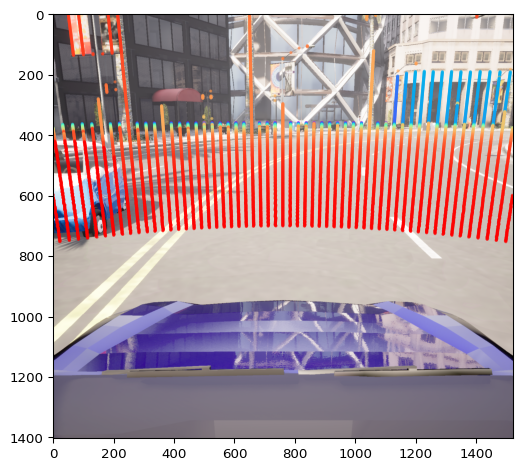

In [21]:
# Convert to homogenous coords .
points = pcd.point['positions'].numpy()
points = np.insert(points, 3, 1, axis=1)
t_camera_intrinsic = np.insert(camera_intrinsic, 3, 0, axis=1)

# Get camera extrinics
camera_extrinsic = np.linalg.inv(camera_pose)

# The camera intrinsic matrix converts from camera coords to image coords through another pre-multiplication. We can combine both operations into one 4x4 projection matrix that we can apply to all points in the PCD.
proj_matrix = t_camera_intrinsic.dot(camera_extrinsic)
im_coords = proj_matrix.dot(points.T)

# Convert back from homogenous coords to pixel coords.
im_coords[:2] /= im_coords[2, :]

# Filter points outside the image or behind the camera.
u, v, z = im_coords
im = mpimg.imread(im_file)
im_height, im_width, _ = im.shape
u_in_mask = np.logical_and(u >= 0, u < im_width)
v_in_mask = np.logical_and(v >= 0, v < im_height)
z_in_mask = z > 0
inliers_mask = np.logical_and(np.logical_and(u_in_mask, v_in_mask), z_in_mask)

# Display points in image, coloured according to depth.
plt.figure(figsize=(12,5), dpi=96, tight_layout=True)
plt.axis([0, im_width, im_height, 0])
u_in, v_in, z_in = im_coords[:, inliers_mask]
plt.scatter([u_in], [v_in], c=[z_in], cmap='rainbow_r', alpha=0.5, s=2)
plt.imshow(im)
plt.show()

# Step 3 - Validate location poses

In this step, we'll visualize the pointcloud and the poses in world coordinates, but sampled every 10 frames.

.csv and .json are supported for the pose(see scene001 and scene002 examples respectively): 
- x,y,z,rotation_x,rotation_y,rotatation_z,rotation_w

The Sama Platform also supports the pose format where each frame is represented by it's own .csv/.json file.

In [22]:
pcds_fixed_world = []
poses_viz = []
downsample_poses_for_viz = 10

location_pose_dir = f"{scene_dir}/location_poses/"
location_pose_filenames_csv = [f for f in sorted(os.listdir(location_pose_dir)) if os.path.splitext(f)[1] == '.csv']
location_pose_filenames_json = [f for f in sorted(os.listdir(location_pose_dir)) if os.path.splitext(f)[1] == '.json']

# Get the CSV or JSON pose file
if not len(location_pose_filenames_csv) ^ len(location_pose_filenames_json):
    raise Exception("must have only csvs or only jsons")
elif len(location_pose_filenames_csv):
    location_pose_filenames = location_pose_filenames_csv
    with open(location_pose_dir + location_pose_filenames[0], 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        csv_or_json_data = list(reader)
elif len(location_pose_filenames_json):
    location_pose_filenames = location_pose_filenames_json
    with open(location_pose_dir + location_pose_filenames[0], 'r') as jsonfile:
        csv_or_json_data = json.load(jsonfile)

for i, location_pose in enumerate(csv_or_json_data[::downsample_poses_for_viz]):

    # Read in the pose (position and rotation).
    position = np.array([location_pose['x'],location_pose['y'],location_pose['z']])
    rotation_quat_xyzw = np.array([location_pose['rotation_x'],location_pose['rotation_y'],location_pose['rotation_z'],location_pose['rotation_w']])
    rotation_matrix = R.from_quat(rotation_quat_xyzw).as_matrix()

    # Construct the fixed-world world->vehicle transformation matrix.
    vehicle_pose_in_world_coords = np.eye(4)
    vehicle_pose_in_world_coords[:3, :3] = rotation_matrix
    vehicle_pose_in_world_coords[:3, 3] = position.T
    transformation_vehicle_to_world = vehicle_pose_in_world_coords

    p = o3d.geometry.TriangleMesh.create_coordinate_frame().transform(vehicle_pose_in_world_coords)
    poses_viz.append(p)

    index = i * downsample_poses_for_viz
    if index < len(pcd_filenames):
        pcd = o3d.io.read_point_cloud(pcd_dir + pcd_filenames[index])
        pcd.transform(transformation_vehicle_to_world)    
        pcds_fixed_world.append(pcd)


fixed_world_origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=3.0)
o3d.visualization.draw_geometries([fixed_world_origin] + pcds_fixed_world + poses_viz)

# Next Steps

Congrats, you can now try creating task yourself via our [APIs](https://docs.sama.com) and even send pre-annotations along with it!

Before can you send us your data to us via API, your pointcloud files must be contained in a .zip file (without any subfolders).
For example, pointcloud.zip will contain 001.pcd, 002.pcd, 003.pcd without a subfolder!